<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# Exercise 4 - Generalized midpoint rule, Newton iterations

The ODE $\dot{y} = k (y_\text{eq} - y)$ is to be integrated numerically.

First, we import some libraries for numerical basics and for plotting.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
#plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (8, 6)

We first code the analytical solution of the ODE in order to have something to compare against.

$\displaystyle \frac{\text{d}y}{y_\text{eq}-y} = k\,\text{d}t \quad \rightarrow \quad \int \limits_0^t k\,\text{d}\bar{t} = \int \limits_{y_0}^y \displaystyle \frac{\text{d}\bar{y}}{y_\text{eq}-\bar{y}}$

$kt = \displaystyle \left. - \ln (y_\text{eq}-\bar{y}) \right|^y_{y_0}$

$\exp (-kt) = \displaystyle \frac{y_\text{eq}-y}{y_\text{eq}-y_0}$

$y = y_\text{eq} - (y_\text{eq} - y_0) \exp (-kt)$

Let's define the equilibrium value and the rate constant as global variables

In [38]:
y_eq = 1.
k = 2.

In [39]:
def y_analytical(t,y_0):
    return y_eq - (y_eq - y_0)*np.exp(-k*t)

According to the ODE definition $\dot{y}=f[y(t),t]$ we define the rate function itself:

In [40]:
def dy_dt(y):
    return k*(y_eq - y)

Let's plot the function and its rate for some exemplary values ($y_0 = 0$) in a time interval $t \in [0,4]$:

In [41]:
time = np.linspace(0,4,100)

Text(0, 0.5, '$y$, $\\dot{y}$ / s$^{-1}$')

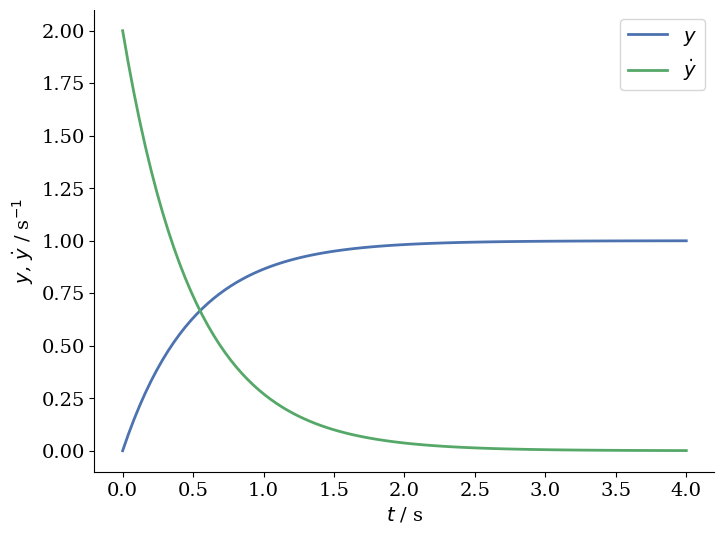

In [42]:
plt.plot(time,y_analytical(time,0),label='$y$')
plt.plot(time,dy_dt(y_analytical(time,0)),label='$\\dot{y}$')
plt.legend()
plt.xlabel('$t$ / s')
plt.ylabel('$y$, $\\dot{y}$ / s$^{-1}$')

Now we want to get the same result with a generalized midpoint rule. It can be considered as a weighted average between an explicit forward Euler and an implicit backward Euler scheme. For the generalized $\alpha$-scheme we find the approximation of the time-discrete rate as

$$\displaystyle \frac{y_{n+1}- y_n}{t_{n+1} - t_n} = [(1-\alpha) f(y_n) + \alpha f(y_{n+1})]$$

This can be re-cast in a residual form, i.e based on an approximation error:

$$r(y_{n+1}) = \displaystyle \frac{y_{n+1}- y_n}{t_{n+1} - t_n} - [(1-\alpha) f(y_n) + \alpha f(y_{n+1})]$$

where we would like to find the solution $y_{n+1}$ such that $r(y_{n+1}) = 0$.

Due to the non-linear dependence of $r$ on the sought solution $y_{n+1}$, the equation cannot be solved directly. We thus use the concepts of a Taylor series expansion truncated after the first member to arrive at a recursive expression:

$$r(y_{n+1}) \approx r(y_n) + \left. \frac{\partial r}{\partial y} \right|_n \underbrace{(y_{n+1} - y_n)}_{\displaystyle \Delta y_{n+1}} \overset{!}{=} 0$$

Thus, with the help of the linearization we proceed from the known solution to the new one in a linear step

$$
    y_{n+1} = y_n - \left( \left. \frac{\partial r}{\partial y} \right|_n \right)^{-1} r(y_n)
$$

Because this is only a linear step, we make an error (truncation error of the Taylor series expansion). Thus, we take the new guess for $y_{n+1}$ to repeat the above step recursively until we arrive at a satisfactory solution (linearization always around the newly found state):

$$
    y_{n+1}^{i+1} = y_{n+1}^{i} - \left( \left. \frac{\partial r}{\partial y} \right|_{i} \right)^{-1} r(y_{n+1}^i)
$$

To perform this update, we need two incredients: a residual evaluation and a Jacobian evaluation (aka "linear slope").

In [43]:
def residual(y_i,y_n,alpha,dt):
    return (y_i - y_n)/dt - ((1.-alpha) * dy_dt(y_n) + alpha * dy_dt(y_i))

In [44]:
def df_dy():
    return -k

In [45]:
def jacobian(alpha,dt):
    return 1./dt - alpha * df_dy()

Note, that the Jacobian is constant for a given time step size (usually it is not!!). Thus, in the present case a distinction between Newton-Raphson, modified Newton, or initial stiffness methods is immaterial. In other words, an initial stiffness approach can be chosen here without any loss of convergence quality. We will demonstrate the full Newton-Raphson scheme below.

The Newton update function is then as follows (returns $\Delta y_{n+1}^{i+1} = y_{n+1}^{i+1} - y_{n+1}^i$):

In [46]:
def Newton_Update(res,Jac):
    return -res/Jac

Now, for every time step we advance the system by applying the generalized midpoint Newton-Raphson update rule. Each new time step value then serves as the initial condition for the following linearization step.

We will *recursively* apply the Newton update until the residual is below a specified tolerance:

$\left| r_{n+1}^{i+1}\right| < \epsilon_\text{abs}$

with a suitably chosen absolute tolerance set here to $10^{-6}$.


In [47]:
def integrate(dt,alpha):
    #Startwerte
    t_end = 4.
    absolute_tolerance = 1.e-6
    max_iter = 1000
    iteration_counter = np.array([0])
    y = np.array([0.])
    times = np.array([0.])
    #
    while times[-1]+dt < t_end: #repeat the loop as long as the final time step is below the end point
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = y[-1] #Starting value for recursive update
        i = 0
        #
        while True:
            #evaluate residual
            res = residual(y_old,y[-1],alpha,dt)
            #if residual is below tolerance, above maximum iterations, stop iterations
            if (np.abs(res) < absolute_tolerance or i > max_iter): 
                break
            #evaluate Jacobian
            Jac = jacobian(alpha,dt)
            #perform linear step
            y_new = y_old + Newton_Update(res,Jac)
            #update counter
            i += 1
            y_old = y_new #preparation of next recursion

        y = np.append(y,y_new) #append the new found solution to the solution vector
        iteration_counter = np.append(iteration_counter,i) #store how much iterations this time step took to converge
    return times, y, iteration_counter


In [48]:
from ipywidgets import widgets
from ipywidgets import interact

@interact(dt=widgets.BoundedFloatText(value=0.2,min=1e-3,max=1,step=0.1,description='$\Delta t$ / s'),
          alpha=widgets.RadioButtons(options=[0,0.5,1], value=1, description='$\\alpha$'))

def plot_CN(dt=0.1,alpha=1):
    time_n, y_n, iter = integrate(dt,alpha)
    fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(18,12))
    #solution
    ax[0][0].plot(time,y_analytical(time,0),label='analytical')
    ax[0][0].plot(time_n,y_n,label='numerical',marker='d',ls=':')
    ax[0][0].legend()
    ax[0][0].set_xlabel('$t$ / s')
    ax[0][0].set_ylabel('$y$')
    #error
    ax[0][1].plot(time_n,y_n-y_analytical(time_n,0),ls=':',marker='d',label='absolute')
    ax[0][1].plot(time_n[1:],(y_n[1:]-y_analytical(time_n[1:],0))/y_analytical(time_n[1:],0),
               ls=':',marker='d',label='relative')
    ax[0][1].legend()
    ax[0][1].set_xlabel('$t$ / s')
    ax[0][1].set_ylabel('error')
    #iterations
    ax[1][0].plot(iter)
    ax[1][0].set_xlabel('time step')
    ax[1][0].set_ylabel('number of iterations')
    
    plt.show()

interactive(children=(BoundedFloatText(value=0.2, description='$\\Delta t$ / s', max=1.0, min=0.001, step=0.1)…

We can also plot the error:

Tasks:

- Compare the number of iterations with the Picard implementation (Exercise 3)
- Investigate the influence of the time-step size
- Repeat the analysis for $\alpha = 1$ (Backward Euler)
- How does the solution change for the modified NR method and the initial stiffness method?
- Repeat the analysis for a function with a non-constant Jacobian (one example is in lecture notes, but you may choose any other)
